<font size="7">Pet segmentation</font>

<font size="5">Group: HAT</font>

<font size="5">Instructor: Dr. Lê Thành Sách</font>

| Name            | ID |
| --------------- | --- |
| Nguyễn Thiên Ân | 2270710 |
| Huỳnh Nhữ Hùng  | 2270712 |
| Nguyễn Thanh Khải Tâm | 2270163 |

The target of this project is to utilize the UNet model to find pets in an image. The dataset used to train and test the model is the Oxford-IIIT Pet Dataset.

#Import libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, concatenate

# Utils
import os
import numpy as np
import time
from PIL import Image
from decimal import Decimal
import matplotlib.pyplot as plt
from keras import backend as K
%matplotlib inline

# Pytorch
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision.transforms import functional as F

# Setup environment

To remain the Colab active while hanging the machine, press ```Ctrl + Shift + I``` and paste the following block of code to the Console:

```
function ClickConnect(){
  colab.config
  console.log("Connnect Clicked - Start");
  document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click();
  console.log("Connnect Clicked - End");
};
setInterval(ClickConnect, 60000)
```

In [ ]:
import tensorflow as tf
print(tf.version.VERSION)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU not found')
print('GPU found {}'.format(device_name))

2.14.0
GPU found /device:GPU:0


In [ ]:
# View Cuda information
!nvidia-smi

Mon Nov 13 17:10:22 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   75C    P0    34W /  70W |    565MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Mount google drive into this notebook
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Setup files and necessary paths

In [ ]:
# Create record text files
!touch "/content/train_losses.txt"
!touch "/content/val_losses.txt"
!touch "/content/val_dice_scores.txt"

# Dataset and model overview

## Dataset overview

The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200 images for each class. The images have large variations in scale, pose and lighting. All images have an associated ground truth annotation of breed, head ROI, and pixel level trimap segmentation.
There are two classes to classify: **{"background": 0, "pet": 1}**.

![Pet dataset](https://drive.google.com/uc?export=view&id=1KuyVHz9Y6toJr-HxrulWcjoPKnYSppTV)

### Download and unzip the dataset

In [ ]:
import tensorflow_datasets as tfds
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

### Helper functions

In [ ]:
def resize(input_image, input_mask):
   input_image = tf.image.resize(input_image, (128, 128), method="nearest")
   input_mask = tf.image.resize(input_mask, (128, 128), method="nearest")
   return input_image, input_mask
def augment(input_image, input_mask):
   if tf.random.uniform(()) > 0.5:
       # Random flipping of the image and mask
       input_image = tf.image.flip_left_right(input_image)
       input_mask = tf.image.flip_left_right(input_mask)
   return input_image, input_mask
def normalize(input_image, input_mask):
   input_image = tf.cast(input_image, tf.float32) / 255.0
   input_mask = tf.cast(input_mask, tf.float32) / 255.0
   #input_mask -= 1
   return input_image, input_mask
def load_image_train(datapoint):
   input_image = datapoint["image"]
   input_mask = datapoint["segmentation_mask"]
   input_image, input_mask = resize(input_image, input_mask)
   input_image, input_mask = augment(input_image, input_mask)
   input_image, input_mask = normalize(input_image, input_mask)
   return input_image, input_mask

def load_image_test(datapoint):
   input_image = datapoint["image"]
   input_mask = datapoint["segmentation_mask"]
   input_image, input_mask = resize(input_image, input_mask)
   input_image, input_mask = normalize(input_image, input_mask)
   return input_image, input_mask

### Explore the dataset

The dataset is part of TensorFlow datasets. Version 3 and higher of the dataset has ground truth segmentation masks.

The dataset already contained test and train splits.

In [ ]:
dataset

{'train': <_PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 'species': TensorSpec(shape=(), dtype=tf.int64, name=None)}>,
 'test': <_PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 'species': TensorSpec(shape=(), dtype=tf.int64, name=None)}>}

In [ ]:
info

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_dir='/root/tensorflow_datasets/oxford_iiit_pet/3.2.0',
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=uint8),
        'species': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    spl

As shown above, the dataset has 7349 images where there are 3680 train images and 3669 test images.

Below are the images and their segmentation mask randomly taken from the train set.

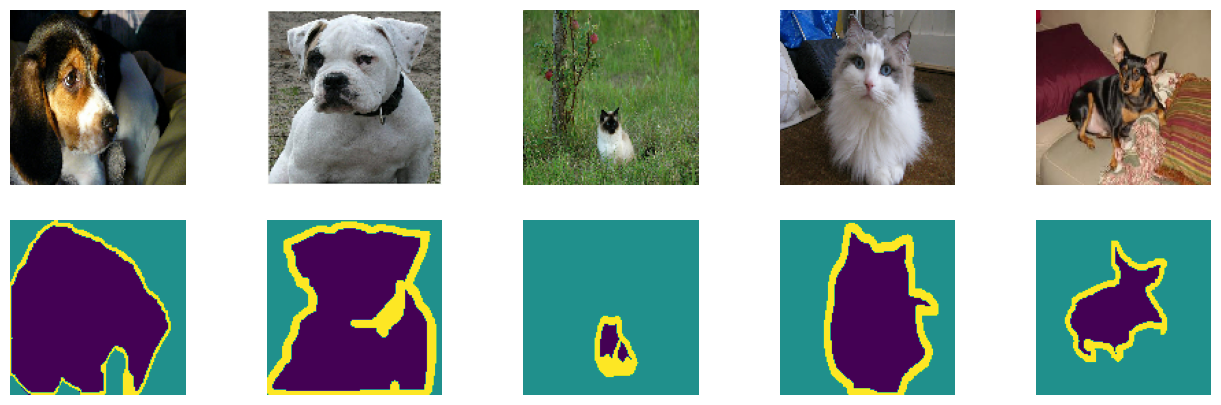

In [ ]:
f_vis, ax_vis = plt.subplots(2, 5, figsize = (16,5))
for idx,(img, mask) in enumerate(dataset["train"].shuffle(buffer_size=10000).map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE).take(5)):
    ax_vis[0, idx].imshow(tf.keras.preprocessing.image.array_to_img(img))
    ax_vis[0, idx].axis('off')
    mask = tf.reshape(mask, [128,128])
    ax_vis[1, idx].imshow(mask.numpy())
    ax_vis[1, idx].axis('off')

## UNet model

UNET is an architecture developed by Olaf Ronneberger et al. for Biomedical Image Segmentation in 2015 at the University of Freiburg, Germany. It is one of the most popularly used approaches in any semantic segmentation task at the time.

![UNet architecture](https://drive.google.com/uc?export=view&id=1d3nCpNVciqquvXqtdJZ4xdtVQCuEdPMV "UNet architecture")

UNET is a U-shaped **encoder-decoder** network architecture, which consists of four encoder blocks and four decoder blocks that are connected via a bridge. The encoder network (contracting path) half the spatial dimensions and double the number of filters (feature channels) at each encoder block. Likewise, the decoder network doubles the spatial dimensions and half the number of feature channels. It also contains a **bridge** that connects the encoder and decoder networks.

The **encoder** (the left side of the "U" in the architecture) acts as feature extractor. Each of the "rows" consists of 2 3x3 convolutional layers with a ReLU activation function. The output of the ReLU acts as a "skip connection" to the corresponding block on the decoder side. A "skip connection" acts as a shortcut connection that helps the indirect flow of gradients to the earlier layers without any degradation. Afterwards, a layer of 2x2 max pooling is used which effectively reduces the height and width by half. This reduces the computational cost by decreasing the number of trainable parameters.

The **bridge** connects the encoder and decoder. It has 2 3x3 convolutional layers.

The **decoder** (the right side of the "U" in the architecture) takes the abstract representation and generate a semantic segmentation mask. Firstly, a 2x2 transpose convolution is used. It is concatenated with the corresponding skip connection feature map from the encoder block.

# Implementation

## Build train & test dataset

In [ ]:
train_dataset = dataset["train"].map(load_image_train, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = dataset["test"].map(load_image_test, num_parallel_calls=tf.data.AUTOTUNE)

## Visualize the augmentation

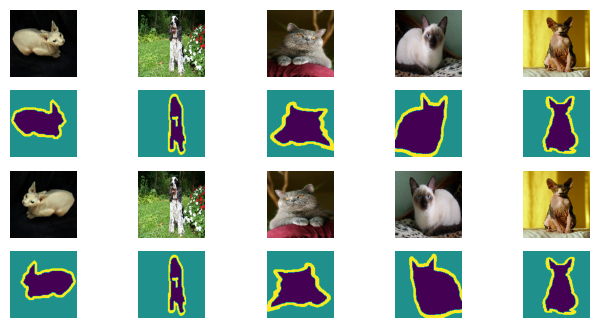

In [ ]:
f, ax = plt.subplots(4, 5, figsize = (8,4))
for idx1,(img1, mask1) in enumerate(train_dataset.take(5)):
    ax[0, idx1].imshow(tf.keras.preprocessing.image.array_to_img(img1))
    ax[0, idx1].axis('off')
    mask = tf.reshape(mask, [128,128])
    ax[1, idx1].imshow(mask1.numpy())
    ax[1, idx1].axis('off')
    img1_aug, mask1_aug = augment(img1,mask1)
    ax[2, idx1].imshow(tf.keras.preprocessing.image.array_to_img(img1_aug))
    ax[2, idx1].axis('off')
    ax[3, idx1].imshow(mask1_aug.numpy())
    ax[3, idx1].axis('off')

## Build Unet class

In [ ]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
train_batches = train_dataset.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_batches = train_batches.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_batches = test_dataset.take(3000).batch(BATCH_SIZE)
test_batches = test_dataset.skip(3000).take(669).batch(BATCH_SIZE)

In [ ]:
def double_conv_block(x, n_filters):
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   # Conv2D then ReLU activation
   x = layers.Conv2D(n_filters, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(x)
   return x

def downsample_block(x, n_filters):
   f = double_conv_block(x, n_filters)
   p = layers.MaxPool2D(2)(f)
   p = layers.Dropout(0.3)(p)
   return f, p

def upsample_block(x, conv_features, n_filters):
   # upsample
   x = layers.Conv2DTranspose(n_filters, 3, 2, padding="same")(x)
   # concatenate
   x = layers.concatenate([x, conv_features])
   # dropout
   x = layers.Dropout(0.3)(x)
   # Conv2D twice with ReLU activation
   x = double_conv_block(x, n_filters)
   return x

def build_unet_model():
   inputs = layers.Input(shape=(128,128,3))
   # encoder: contracting path - downsample
   # 1 - downsample
   f1, p1 = downsample_block(inputs, 64)
   # 2 - downsample
   f2, p2 = downsample_block(p1, 128)
   # 3 - downsample
   f3, p3 = downsample_block(p2, 256)
   # 4 - downsample
   f4, p4 = downsample_block(p3, 512)
   # 5 - bottleneck
   bottleneck = double_conv_block(p4, 1024)
   # decoder: expanding path - upsample
   # 6 - upsample
   u6 = upsample_block(bottleneck, f4, 512)
   # 7 - upsample
   u7 = upsample_block(u6, f3, 256)
   # 8 - upsample
   u8 = upsample_block(u7, f2, 128)
   # 9 - upsample
   u9 = upsample_block(u8, f1, 64)
   # outputs
   outputs = layers.Conv2D(3, 1, padding="same", activation = "softmax")(u9)
   # unet model with Keras Functional API
   unet_model = tf.keras.Model(inputs, outputs, name="U-Net")
   return unet_model

In [ ]:
def unet_model(input_shape):
    inputs = Input(input_shape)

    # Encoder
    conv1 = Conv2D(32, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, 3, activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    # Bottom
    conv5 = Conv2D(512, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, 3, activation='relu', padding='same')(conv5)

    # Decoder
    up6 = Conv2D(256, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv5))
    merge6 = concatenate([conv4, up6], axis=3)
    conv6 = Conv2D(256, 3, activation='relu', padding='same')(merge6)
    conv6 = Conv2D(256, 3, activation='relu', padding='same')(conv6)

    up7 = Conv2D(128, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv6))
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(128, 3, activation='relu', padding='same')(merge7)
    conv7 = Conv2D(128, 3, activation='relu', padding='same')(conv7)

    up8 = Conv2D(64, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv7))
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(64, 3, activation='relu', padding='same')(merge8)
    conv8 = Conv2D(64, 3, activation='relu', padding='same')(conv8)

    up9 = Conv2D(32, 2, activation='relu', padding='same')(UpSampling2D(size=(2, 2))(conv8))
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(32, 3, activation='relu', padding='same')(merge9)
    conv9 = Conv2D(32, 3, activation='relu', padding='same')(conv9)

    # Output
    outputs = Conv2D(num_classes, 1, activation='softmax')(conv9)

    model = Model(inputs=inputs, outputs=outputs)
    return model


In [ ]:
#unet_model = build_unet_model()
input_shape = (128, 128, 3)
num_classes = 2
unet_model = unet_model(input_shape)

In [ ]:
def dice_loss(y_true, y_pred):
    smooth = 1e-5
    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    dice_coef = (2.0 * intersection + smooth) / (union + smooth)
    return 1.0 - dice_coef

In [ ]:
num_classes = 2 #background and pet
def mean_iou(y_true, y_pred):
    return MeanIoU(num_classes=num_classes)(y_true, tf.round(y_pred))

In [ ]:
unet_model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss= dice_loss,metrics=[mean_iou])#, metrics = [tf.keras.metrics.IoU(num_classes=2, target_class_ids=[0])])
                   #loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits =True), metrics=['accuracy'])

In [ ]:
unet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d_79 (Conv2D)          (None, 128, 128, 32)         896       ['input_5[0][0]']             
                                                                                                  
 conv2d_80 (Conv2D)          (None, 128, 128, 32)         9248      ['conv2d_79[0][0]']           
                                                                                                  
 max_pooling2d_16 (MaxPooli  (None, 64, 64, 32)           0         ['conv2d_80[0][0]']           
 ng2D)                                                                                        

## Train the model

In [ ]:
NUM_EPOCHS = 15
TRAIN_LENGTH = info.splits["train"].num_examples
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
VAL_SUBSPLITS = 5
TEST_LENTH = info.splits["test"].num_examples
VALIDATION_STEPS = TEST_LENTH // BATCH_SIZE // VAL_SUBSPLITS
model_history = unet_model.fit(train_batches,
                              epochs=NUM_EPOCHS,
                              steps_per_epoch=STEPS_PER_EPOCH,
                              validation_steps=VALIDATION_STEPS,
                              validation_data=test_batches,callbacks=tf.keras.callbacks.EarlyStopping(patience=3,restore_best_weights=True))


Epoch 1/15


ValueError: ignored

In [ ]:
NUM_EPOCHS = 15
TRAIN_LENGTH = info.splits["train"].num_examples
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE
VAL_SUBSPLITS = 5
TEST_LENTH = info.splits["test"].num_examples
VALIDATION_STEPS = TEST_LENTH // BATCH_SIZE // VAL_SUBSPLITS
model_history = unet_model.fit(train_batches,
                              epochs=NUM_EPOCHS,
                              steps_per_epoch=STEPS_PER_EPOCH,
                              validation_steps=VALIDATION_STEPS,
                              validation_data=test_batches,callbacks=tf.keras.callbacks.EarlyStopping(patience=3,restore_best_weights=True))

Epoch 1/15
57/57 [==============================] - 86s 1s/step - loss: 280.1859 - val_loss: 278.2477
Epoch 2/15
 1/57 [..............................] - ETA: 27s - loss: 275.2363

KeyboardInterrupt: ignored

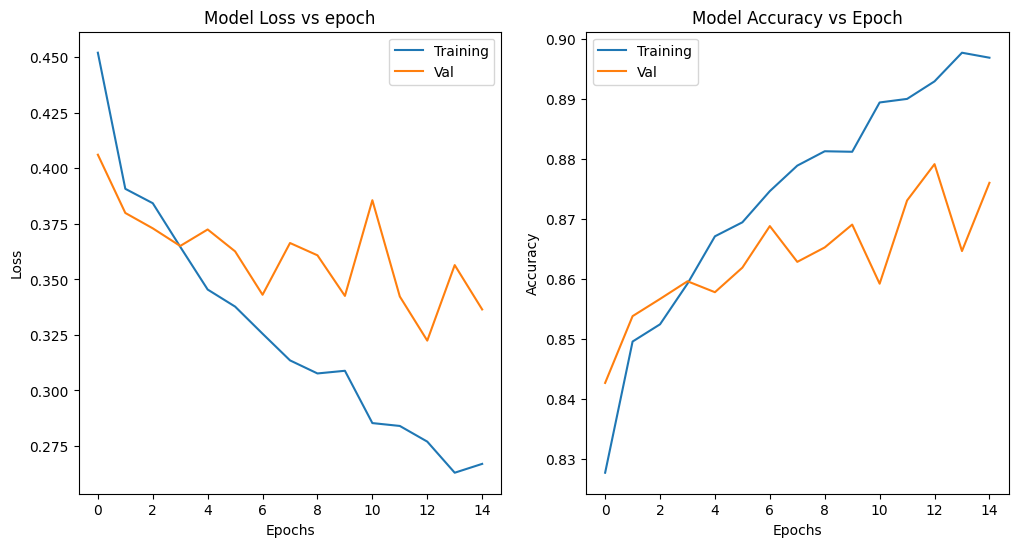

In [ ]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(model_history.history['loss'], label='Training')
plt.plot(model_history.history['val_loss'], label='Val')
plt.title('Model Loss vs epoch')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Epochs')

plt.subplot(1,2,2)
plt.plot(model_history.history['accuracy'], label='Training')
plt.plot(model_history.history['val_accuracy'], label='Val')
plt.title('Model Accuracy vs Epoch')
plt.legend()
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.show()

In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]
def show_predictions(dataset=None, num=1):
  if dataset:
   for image, mask in dataset.take(num):
     pred_mask = unet_model.predict(image)
     display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
            create_mask(model.predict(sample_image[tf.newaxis, ...]))])
count = 0
for i in test_batches:
   count +=1
print("number of batches:", count)
def display(display_list):
 plt.figure(figsize=(15, 15))
 title = ["Input Image", "True Mask", "Predicted Mask"]
 for i in range(len(display_list)):
   plt.subplot(1, len(display_list), i+1)
   plt.title(title[i])
   plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
   plt.axis("off")
 plt.show()

number of batches: 11


2/2 [==============================] - 0s 168ms/step


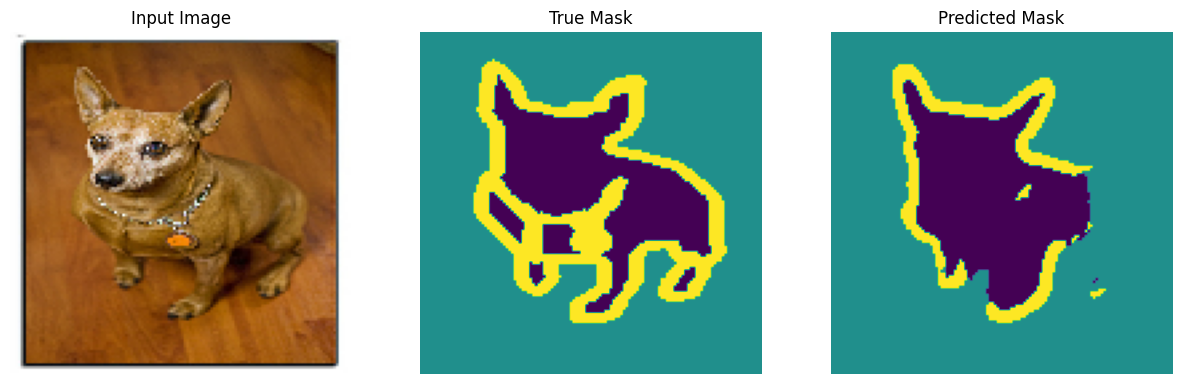

2/2 [==============================] - 0s 123ms/step


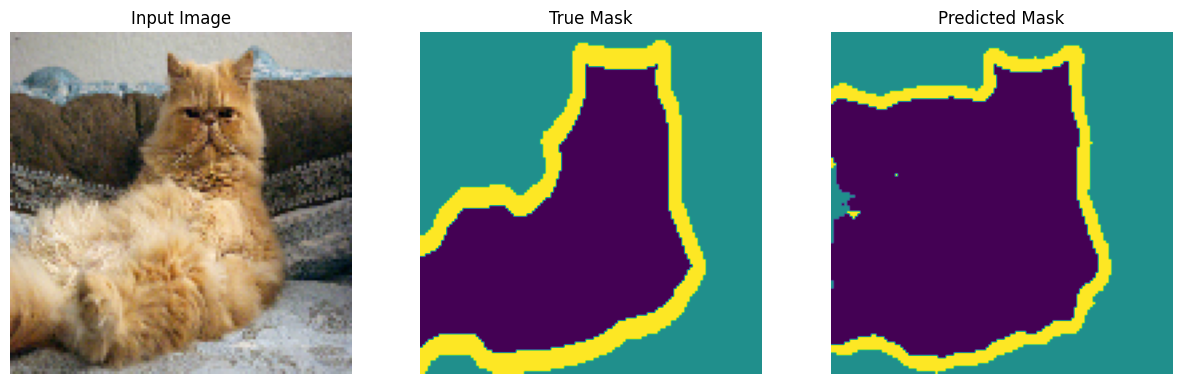

2/2 [==============================] - 0s 122ms/step


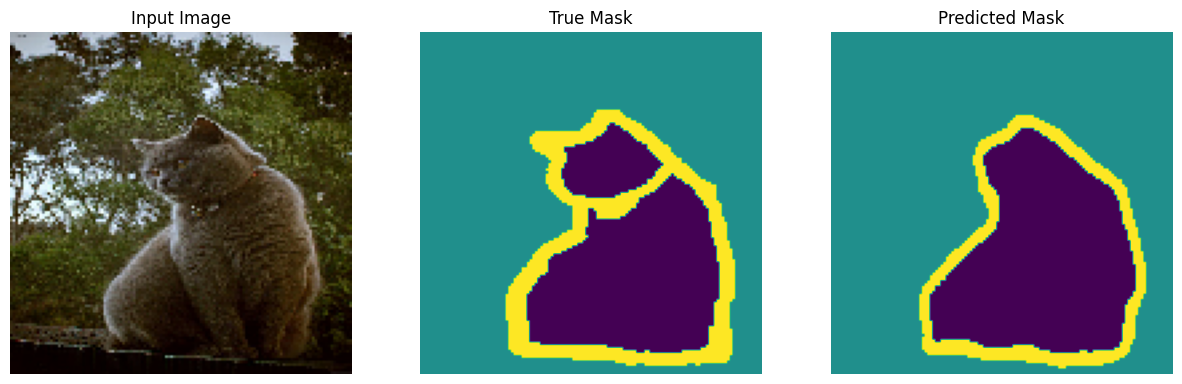

2/2 [==============================] - 0s 132ms/step


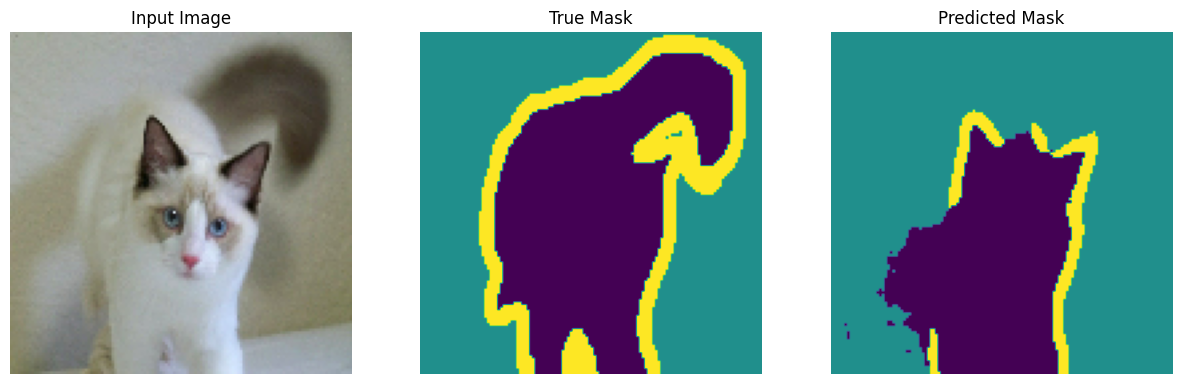

2/2 [==============================] - 0s 126ms/step


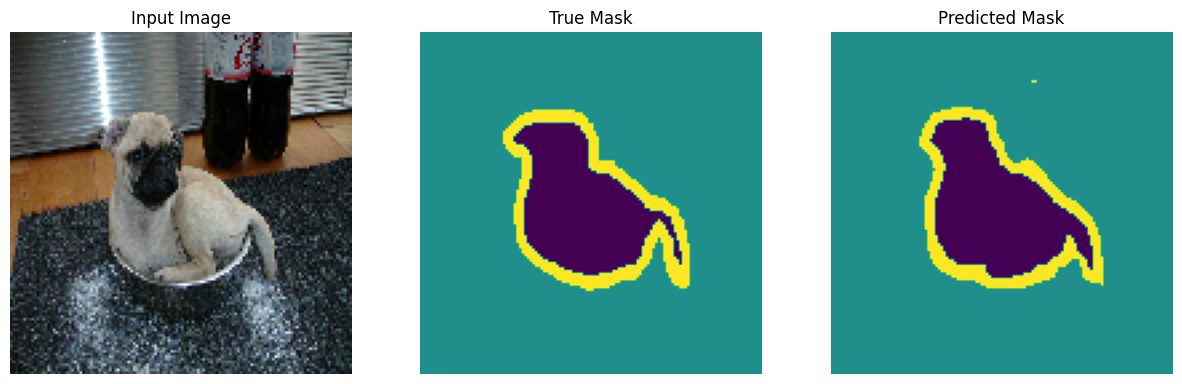

2/2 [==============================] - 0s 126ms/step


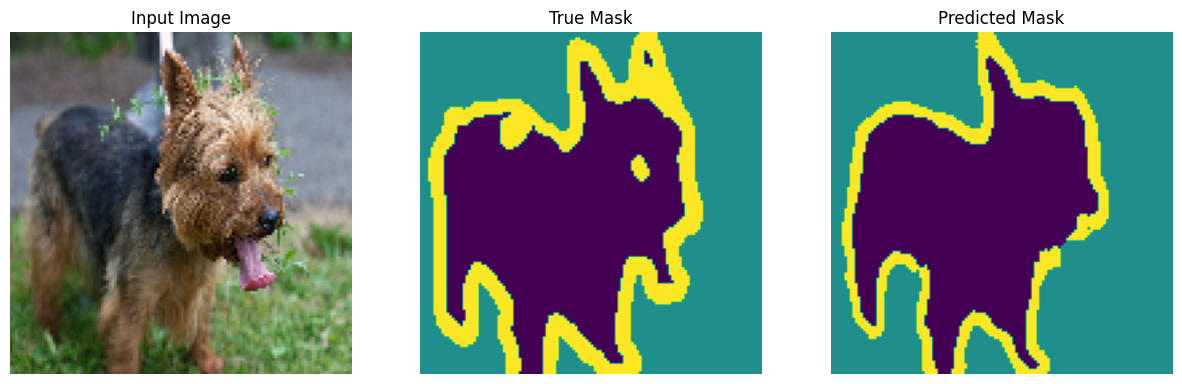

2/2 [==============================] - 0s 128ms/step


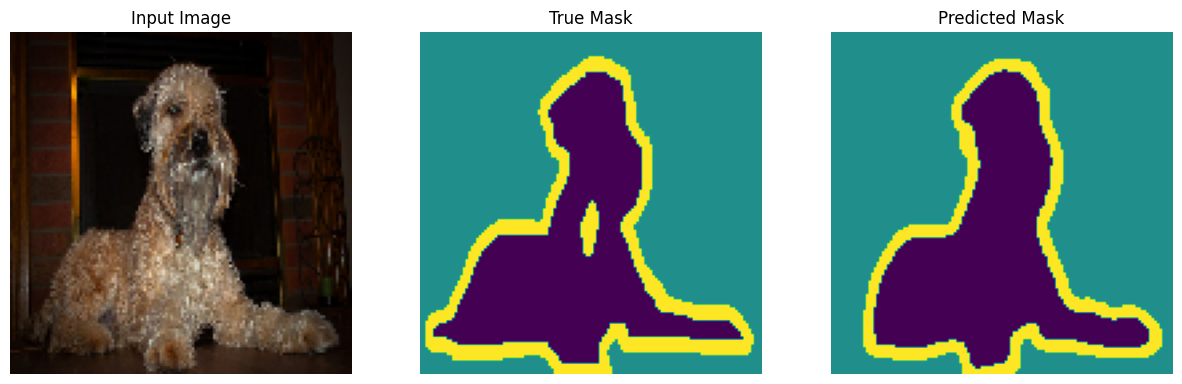

2/2 [==============================] - 0s 123ms/step


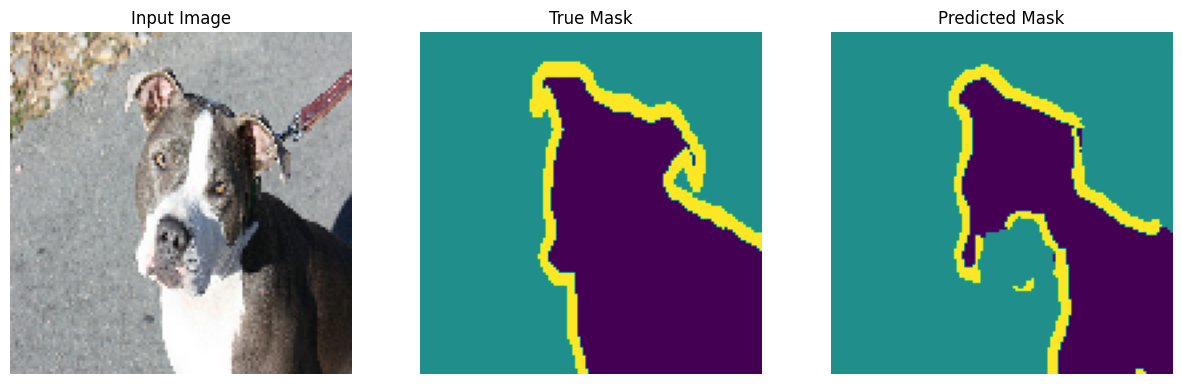

In [ ]:
show_predictions(test_batches, 8)

## Model evaluation